In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable

from IPython import display
import time

from PIL import Image

import copy
import subprocess as sp

def tovar(x):
    return torch.cuda.FloatTensor(x)

def toivar(x):
    return torch.cuda.LongTensor(x)

In [10]:
class metaLinear(nn.Module):
    def __init__(self, Nin, Nout):
        super(metaLinear,self).__init__()
        
        self.betaW = Parameter(torch.FloatTensor(np.ones(1)*5e-3))
        self.betaB = Parameter(torch.FloatTensor(np.ones(1)*5e-3))
        
        self.layer = nn.Linear(Nin, Nout)
        nn.init.orthogonal_(self.layer.weight, gain=sqrt(2))
    
    def forward(self, x, meta=False):
        if meta:
            return F.linear(x,
                            weight=self.layer.weight + self.dweight, 
                            bias=self.layer.bias + self.dbias)
        else:
            self.dweight = torch.zeros_like(self.layer.weight)
            self.dbias = torch.zeros_like(self.layer.bias)
        
            return F.linear(x,
                            weight=self.layer.weight, 
                            bias=self.layer.bias)
    
    def update(self, loss):
        gradW, gradB = torch.autograd.grad([loss], [self.layer.weight, self.layer.bias], 
                                           retain_graph=True, create_graph=True)
        gradW = gradW.detach()
        gradB = gradB.detach()
        self.dweight = (self.dweight - self.betaW[0] * gradW)
        self.dbias = (self.dbias - self.betaB[0] * gradB)
        
class Generator(nn.Module):
    def __init__(self, width = 256, noise_d = 16, d=1):
        super(Generator,self).__init__()
        
        self.l1 = nn.Linear(noise_d, width)
        nn.init.orthogonal_(self.l1.weight, gain=sqrt(2))
        self.l2 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l2.weight, gain=sqrt(2))
        self.l3 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l3.weight, gain=sqrt(2))
        self.l4 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l4.weight, gain=sqrt(2))
        self.l5 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        self.l6 = nn.Linear(width, d)
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=1e-3)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma = 0.99)
        
        self.d = d
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = F.relu(self.l4(z))
        z = F.relu(self.l5(z))
        z = self.l6(z)
                
        return z
    
class Discriminator(nn.Module):
    def __init__(self, width = 256, d=1):
        super(Discriminator,self).__init__()
        
        self.l1 = metaLinear(d, width)
        self.l2 = metaLinear(width, width)
        self.l3 = metaLinear(width, width)
        self.l4 = metaLinear(width, width)
        self.l5 = metaLinear(width, width)
        self.l6 = metaLinear(width, 1)
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=1e-3)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma = 0.95)
        self.d = d
        
    def update(self, loss):
        for layer in self.children():
            if "update" in dir(layer):
                layer.update(loss)
                
    def forward(self, x, meta):
        z = F.relu(self.l1(x), meta)
        z = F.relu(self.l2(z), meta)
        z = F.relu(self.l3(z), meta)
        z = F.relu(self.l4(z), meta)
        z = F.relu(self.l5(z), meta)
        z = self.l6(z, meta)
                
        return z[:,0]

In [8]:
def mkDataset(N=1, d=1, seed=1, pts=5000):
  np.random.seed(seed)
  mu = np.random.rand(N,d)*12-6
  
  idx = np.random.randint(N, size=(pts,))
  
  return np.random.randn(pts,d) + mu[idx], mu

In [9]:
def estimate_1d_KL(x, y, p, N=20):
  histx = np.zeros((N))
  histy = np.zeros((N))
  
  idx_x = np.clip(N*(x[:,0]+12)/24, 0, N).astype(np.int32)
  
  for i in range(N):
    histx[i] = np.sum((idx_x == i)*1)
  
  histx = histx / np.sum(histx)
  
  idx_x = np.clip(N*(y[:,0]+12)/24, 0, N).astype(np.int32)

  for i in range(N):
    histy[i] = np.sum((idx_x == i)*1)
  
  histy = histy / np.sum(histy)
  
  nonzero = (histx>0)
  histx = histx[nonzero]
  histy = histy[nonzero]
  
  KL = -np.sum(histx*np.log(histy/histx + 1e-32))
  
  return KL

def estimate_2d_KL(x, y, p, N=20):
  histx = np.zeros((N*N))
  histy = np.zeros((N*N))
  
  idx_x = np.clip(N*(x[:,0]+12)/24, 0, N).astype(np.int32)
  idx_y = np.clip(N*(x[:,1]+12)/24, 0, N).astype(np.int32)
  
  for i in range(N):
    for j in range(N):
      histx[i + N*j] = np.sum((idx_x == i)*(idx_y == j)*1)
  
  histx = histx / np.sum(histx)
  
  idx_x = np.clip(N*(y[:,0]+12)/24, 0, N).astype(np.int32)
  idx_y = np.clip(N*(y[:,1]+12)/24, 0, N).astype(np.int32)
  
  for i in range(N):
    for j in range(N):
      histy[i + N*j] = np.sum((idx_x == i)*(idx_y == j)*p)
  
  histy = histy / np.sum(histy)
  
  nonzero = (histx>0)
  histx = histx[nonzero]
  histy = histy[nonzero]
  
  KL = -np.sum(histx*np.log(histy/histx + 1e-32))
  
  return KL

def estimate_3d_KL(x, y, p, N=20):
  histx = np.zeros((N*N*N))
  histy = np.zeros((N*N*N))
  
  idx_x = np.clip(N*(x[:,0]+12)/24, 0, N).astype(np.int32)
  idx_y = np.clip(N*(x[:,1]+12)/24, 0, N).astype(np.int32)
  idx_z = np.clip(N*(x[:,2]+12)/24, 0, N).astype(np.int32)
  
  for i in range(N):
    for j in range(N):
      for k in range(N):
        histx[i + N*j + N*N*k] = np.sum((idx_x == i)*(idx_y == j)*(idx_z == k)*1)
  
  histx = histx / np.sum(histx)
  
  idx_x = np.clip(N*(y[:,0]+12)/24, 0, N).astype(np.int32)
  idx_y = np.clip(N*(y[:,1]+12)/24, 0, N).astype(np.int32)
  idx_z = np.clip(N*(y[:,2]+12)/24, 0, N).astype(np.int32)
  
  for i in range(N):
    for j in range(N):
      for k in range(N):
        histy[i + N*j + N*N*k] = np.sum((idx_x == i)*(idx_y == j)*(idx_z == k)*1)
  
  histy = histy / np.sum(histy)
  
  nonzero = (histx>0)
  histx = histx[nonzero]
  histy = histy[nonzero]
  
  KL = -np.sum(histx*np.log(histy/histx + 1e-32))
  
  return KL

def estimate_KL(x, y, p):
  if x.shape[1] == 1:
    return estimate_1d_KL(x,y,p)
  elif x.shape[1] == 2:
    return estimate_2d_KL(x,y,p)
  elif x.shape[1] == 3:
    return estimate_3d_KL(x,y,p)
  
  return 0

def addSubData(hist, x, p, dim, maxdim, N, idx):
    if dim<maxdim:
        xidx = np.clip((N*(x[:,dim]+12)/24), 0, N-1).astype(np.int32)
        for i in range(N):
            keep = xidx == i
            addSubData(hist, x[keep], p[keep], dim+1, maxdim, N, idx + i*(N**dim))
    else:
        hist[idx] = np.sum(p)

def estimate_Nd_KL(x, y, p, N=20):
    d = x.shape[1]

    histx = np.zeros((N**d))
    histy = np.zeros((N**d))
    
    addSubData(histx, x, np.ones(x.shape[0]), 0, d, N, 0)

    addSubData(histy, y, p, 0, d, N, 0)

    nonzero = (histx>0)
    histx = histx[nonzero]
    histy = histy[nonzero]
    
    histy = histy + 1e-32
    histx = histx / np.sum(histx)
    histy = histy / np.sum(histy)

    KL = -np.sum(histx*np.log(histy/histx))

    return KL

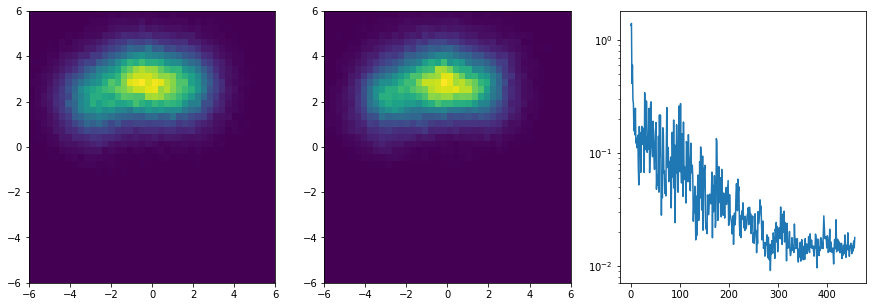

KeyboardInterrupt: 

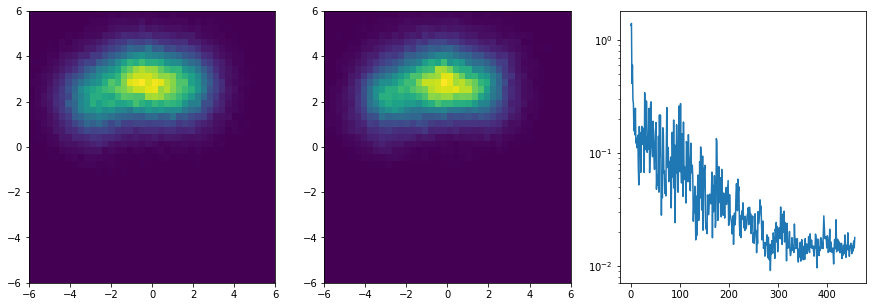

In [20]:
BS = 100

disc = Discriminator(width=32, d=2).cuda()
gen = Generator(width=32, d=2).cuda()

errs = []
KL = []

xall, mu = mkDataset(N=4, d=2, seed=81293, pts=105000)

x = tovar(xall[0:5000])
xtrue = xall[5000:]

idx = torch.arange(BS).long().cuda()

for epoch in range(1000):
    # Joint updates    
    for i in range(x.size(0)//BS):
        # Discriminator
        disc.zero_grad()
        
        xt = x[i*BS:i*BS+BS]
        xf = gen.forward(tovar(np.random.randn(BS, 16)))
        
        pto = disc.forward(xt, False)
        pfo = disc.forward(xf, False)
        pt = F.sigmoid(pto-torch.mean(pfo))
        pf = F.sigmoid(pfo-torch.mean(pto))
        
        loss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
        loss.backward()
        
        disc.optim.step()
        
        # Generator
        gen.zero_grad()
        disc.zero_grad()
        
        for j in range(5):
            xt = x[i*BS:i*BS+BS]
            xf = gen.forward(tovar(np.random.randn(BS, 16)))

            pto = disc.forward(xt, j>0)
            pfo = disc.forward(xf, j>0)
            pt = F.sigmoid(pto-torch.mean(pfo))
            pf = F.sigmoid(pfo-torch.mean(pto))
        
            dloss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
            disc.update(dloss)
        
        gloss = torch.mean(torch.log(pt+1e-8)) + torch.mean(torch.log(1-pf+1e-8))
        
        gloss.backward()
        gen.optim.step()
    
    disc.schedule.step()
    gen.schedule.step()
    
    y = gen.forward(tovar(np.random.randn(100000, 16)))
    y = y.cpu().detach().numpy()
    
    KL.append(estimate_KL(xtrue,y,np.ones(y.shape[0])))

    plt.clf()
    plt.subplot(1,3,1)
    plt.hist2d(xtrue[:,0], xtrue[:,1], 40, range=[[-6,6],[-6,6]])

    plt.subplot(1,3,2)
    plt.hist2d(y[:,0], y[:,1], 40, range=[[-6,6],[-6,6]])
    
    plt.subplot(1,3,3)
    plt.plot(KL)
    plt.yscale("log")

    plt.gcf().set_size_inches((15,5))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [21]:
np.min(KL)

0.00906957877995782

In [14]:
def UnrolledGANScaling(ndata = 50000, d=1, N=1, seed=1):
    BS = 200

    disc = Discriminator(width=32, d=d).cuda()
    gen = Generator(width=32, d=d).cuda()

    errs = []
    KL = []

    xall, mu = mkDataset(N=N, d=d, seed=seed, pts=400000+ndata)

    x = tovar(xall[0:ndata])
    xtrue = xall[ndata:]

    idx = torch.arange(BS).long().cuda()
    
    count = 0

    for epoch in range(50):
        # Joint updates    
        for i in range(x.size(0)//BS):
            # Discriminator
            disc.zero_grad()

            xt = x[i*BS:i*BS+BS]
            xf = gen.forward(tovar(np.random.randn(BS, 16)))

            pto = disc.forward(xt, False)
            pfo = disc.forward(xf, False)
            pt = F.sigmoid(pto-torch.mean(pfo))
            pf = F.sigmoid(pfo-torch.mean(pto))

            loss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
            loss.backward()

            disc.optim.step()

            # Generator
            gen.zero_grad()
            disc.zero_grad()

            for j in range(5):
                xt = x[i*BS:i*BS+BS]
                xf = gen.forward(tovar(np.random.randn(BS, 16)))

                pto = disc.forward(xt, j>0)
                pfo = disc.forward(xf, j>0)
                pt = F.sigmoid(pto-torch.mean(pfo))
                pf = F.sigmoid(pfo-torch.mean(pto))

                dloss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
                disc.update(dloss)

            gloss = torch.mean(torch.log(pt+1e-8)) + torch.mean(torch.log(1-pf+1e-8))

            gloss.backward()
            gen.optim.step()

        disc.schedule.step()
        gen.schedule.step()
        
        if epoch%10 == 9:
            yy = np.zeros((0,xtrue.shape[1]))
            
            for i in range(4):
                y = gen.forward(tovar(np.random.randn(100000, 16)))
                y = y.cpu().detach().numpy()
                yy = np.concatenate([yy,y],axis=0)

            KL.append(estimate_Nd_KL(xtrue,yy,np.ones(yy.shape[0])))

            plt.clf()
            plt.subplot(1,3,1)
            plt.hist(xtrue[:,0], 40, range=[-12,12])

            plt.subplot(1,3,2)
            plt.hist(yy[:,0], 40, range=[-12,12])

            plt.subplot(1,3,3)
            plt.plot(KL)
            plt.yscale("log")

            plt.gcf().set_size_inches((15,5))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)
    
    emp_kl = estimate_Nd_KL(xtrue, xall[0:ndata], np.ones(ndata))
    return KL[-1], np.min(KL), emp_kl

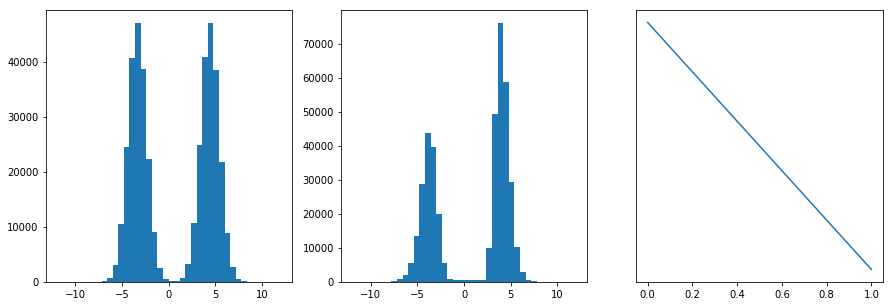

KeyboardInterrupt: 

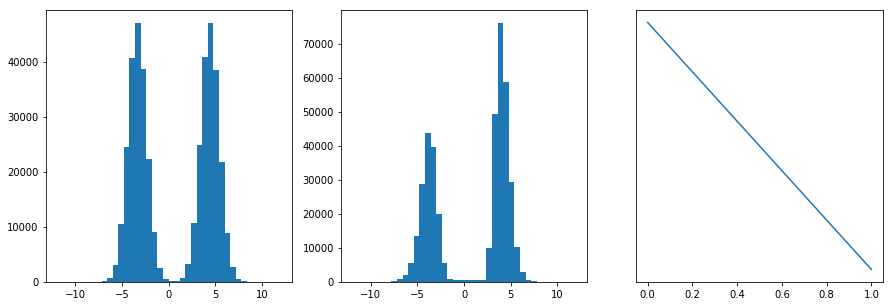

In [15]:
Ds = []
for d in range(1,5):
    print("d=%d" % d)
    Ns = []
    for N in [1,2,4,10]:
        print("N=%d" % N)
        pts = []
        for seed in range(1,6):
            Kf, Km, Ekl = UnrolledGANScaling(d=d,N=N,seed=seed)            
            pts.append(np.array([Kf, Km, Ekl]))
        np.savetxt("d_%d_N_%d.txt" % (d,N), np.array(pts))
        Ns.append(np.array(pts))
    Ds.append(np.array(Ns))
Ds = np.array(Ds)

In [44]:
np.save("unrolledGAN_1d.npy", np.array(Ns))

In [46]:
np.mean(Ns,axis=1)[:,0]

array([0.00343353, 0.00653028])

## N scaling, disabled for now

ns = []
kls = []
mkls = []
ekls = []

for n in range(8):
    ndata = 50 * 2**n
    ns.append(ndata)

    klb = []
    mklb = []
    eklb = []

    for j in range(5):
        kl, mkl, ekl = UnrolledGANScaling(ndata = ndata, d = 1, seed = j+1)

    klb.append(kl)
    mklb.append(mkl)
    eklb.append(ekl)

    kls.append(np.array(klb))
    mkls.append(np.array(mklb))
    ekls.append(np.array(eklb))

    np.savetxt("gan_ns_1d.txt", np.array(ns))
    np.savetxt("gan_kls_1d.txt", np.array(kls))
    np.savetxt("gan_mkls_1d.txt", np.array(mkls))
    np.savetxt("gan_ekls_1d.txt", np.array(ekls))
